In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import sys
import bbknn
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import anndata
import harmonypy as hm

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

2024-05-17 03:44:28.534464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 03:44:28.534572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 03:44:29.166427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 03:44:30.411304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 03:44:50.806491: W tensorflow/compiler/tf2

In [5]:
#import scanpy as sc
#adata=sc.read('/lustre/scratch126/cellgen/team298/ab72/CTCL/ctcl_cellbender_raw_by_pasha_15_5.h5ad')

In [6]:
adata.obs

,sample_type,Donor,Sanger_ID,batch
AAACCTGAGAAACCAT-0,CTCL,CTCL1,WSSS_SKN8090612,0
AAACCTGAGAAACCGC-0,CTCL,CTCL1,WSSS_SKN8090612,0
AAACCTGAGAAACCTA-0,CTCL,CTCL1,WSSS_SKN8090612,0
AAACCTGAGAAACGAG-0,CTCL,CTCL1,WSSS_SKN8090612,0
AAACCTGAGAAACGCC-0,CTCL,CTCL1,WSSS_SKN8090612,0
...,...,...,...,...
TTTGTCATCTTTACAC-38,CTCL,CTCL4,CTCL4_GEX_4,38
TTTGTCATCTTTACGT-38,CTCL,CTCL4,CTCL4_GEX_4,38
TTTGTCATCTTTAGGG-38,CTCL,CTCL4,CTCL4_GEX_4,38
TTTGTCATCTTTAGTC-38,CTCL,CTCL4,CTCL4_GEX_4,38


In [2]:
path1= '/nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/'

In [8]:
file_path=('/lustre/scratch126/cellgen/team298/ab72/CTCL/skin_info.csv')

In [18]:
samples = pd.read_csv(file_path)

In [19]:
samples

,irods/farm,Sample_type,Donor,Sample_id,Tissue,Site,Sex,Unnamed: 7,Unnamed: 8
0,4820STDY7388991,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,NaN,NaN
1,4820STDY7388992,healthy_skin,S1,4820STDY7388992,Dermis,non_lesion,Female,NaN,NaN
2,4820STDY7388993,healthy_skin,S1,4820STDY7388993,Dermis,non_lesion,Female,NaN,NaN
3,4820STDY7388994,healthy_skin,S1,4820STDY7388994,Dermis,non_lesion,Female,NaN,NaN
4,4820STDY7388995,healthy_skin,S1,4820STDY7388995,Epidermis,non_lesion,Female,NaN,NaN
...,...,...,...,...,...,...,...,...,...
131,/lustre/scratch126/cellgen/team205/rl20/CTCL/r...,CTCL,CTCL3,CTCL3_GEX_4,Epidermis,lesion,Female,NaN,NaN
132,/lustre/scratch126/cellgen/team205/rl20/CTCL/r...,CTCL,CTCL4,CTCL4_GEX_1,Dermis,lesion,Male,NaN,NaN
133,/lustre/scratch126/cellgen/team205/rl20/CTCL/r...,CTCL,CTCL4,CTCL4_GEX_2,Dermis,lesion,Male,NaN,NaN
134,/lustre/scratch126/cellgen/team205/rl20/CTCL/r...,CTCL,CTCL4,CTCL4_GEX_3,Epidermis,lesion,Male,NaN,NaN


In [20]:
import os

# Directory path
directory_path = path1

# Get list of all subdirectories
sub = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]



In [21]:
sample_filt = samples.loc[samples['irods/farm'].isin(sub)]


In [22]:
column_list=sample_filt['irods/farm'].tolist()

In [23]:
path2= '/cellbender_out_filtered.h5'

In [24]:
path= [path1+name+path2 for name in column_list]

In [25]:
path

['/nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388991/cellbender_out_filtered.h5',
 '/nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388992/cellbender_out_filtered.h5',
 '/nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388993/cellbender_out_filtered.h5',
 '/nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388994/cellbender_out_filtered.h5',
 '/nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388995/cellbender_out_filtered.h5',
 '/nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388996/cellbender_out_filtered.h5',
 '/nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/re

In [26]:
sample_filt['path']= path
sample_filt

/tmp/ipykernel_411959/2675726948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_filt['path']= path


,irods/farm,Sample_type,Donor,Sample_id,Tissue,Site,Sex,Unnamed: 7,Unnamed: 8,path
0,4820STDY7388991,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,NaN,NaN,/nfs/cellgeni/pasham/projects/2211.adult.skin/...
1,4820STDY7388992,healthy_skin,S1,4820STDY7388992,Dermis,non_lesion,Female,NaN,NaN,/nfs/cellgeni/pasham/projects/2211.adult.skin/...
2,4820STDY7388993,healthy_skin,S1,4820STDY7388993,Dermis,non_lesion,Female,NaN,NaN,/nfs/cellgeni/pasham/projects/2211.adult.skin/...
3,4820STDY7388994,healthy_skin,S1,4820STDY7388994,Dermis,non_lesion,Female,NaN,NaN,/nfs/cellgeni/pasham/projects/2211.adult.skin/...
4,4820STDY7388995,healthy_skin,S1,4820STDY7388995,Epidermis,non_lesion,Female,NaN,NaN,/nfs/cellgeni/pasham/projects/2211.adult.skin/...
...,...,...,...,...,...,...,...,...,...,...
91,SKN8105195,healthy_skin,S5,SKN8105195,Epidermis,non_lesion,Female,NaN,NaN,/nfs/cellgeni/pasham/projects/2211.adult.skin/...
92,SKN8105197,healthy_skin,S5,SKN8105197,Dermis,non_lesion,Female,NaN,NaN,/nfs/cellgeni/pasham/projects/2211.adult.skin/...
93,SKN8105198,healthy_skin,S5,SKN8105198,Dermis,non_lesion,Female,NaN,NaN,/nfs/cellgeni/pasham/projects/2211.adult.skin/...
94,SKN8105199,healthy_skin,S5,SKN8105199,Dermis,non_lesion,Female,NaN,NaN,/nfs/cellgeni/pasham/projects/2211.adult.skin/...


In [27]:
# Initialize a list to store Adata objects
adata_list = []

# Iterate over each row in the DataFrame
for index, row in sample_filt.iterrows():
    # Read Adata file
    adata = sc.read_10x_h5(row['path'])

    # add sample_type and donor
    adata.obs['sample_type'] = row['Sample_type']
    adata.obs['Donor'] = row['Donor']
    adata.obs['Sanger_ID'] = row['irods/farm']
    adata.obs['tissue'] = row['Tissue']
    adata.obs['site'] = row['Site']
    adata.obs['Sex'] = row['Sex']
    
    adata.obs_names_make_unique()
    adata.var_names_make_unique()
    
    # Append the Adata object to the list
    adata_list.append(adata)

# Concatenate all Adata objects
concatenated_adata = adata_list[0].concatenate(adata_list[1:])


reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388991/cellbender_out_filtered.h5
 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388992/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388993/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388994/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388995/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388996/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388997/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388998/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7388999/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389000/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389001/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389002/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389003/cellbender_out_filtered.h5
 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389004/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389005/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389006/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389007/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389008/cellbender_out_filtered.h5
 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389009/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389010/cellbender_out_filtered.h5
 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389011/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389012/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389013/cellbender_out_filtered.h5
 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/4820STDY7389014/cellbender_out_filtered.h5
 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090524/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090525/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090526/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090528/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090529/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090530/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090531/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090536/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090537/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:04)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090538/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:03)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090539/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090540/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090541/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090542/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090543/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090548/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090549/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090550/cellbender_out_filtered.h5
 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090551/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:03)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090552/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090553/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:03)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090554/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090555/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:03)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090560/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090561/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090562/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090563/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090564/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090565/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090567/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090576/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090577/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090578/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090579/cellbender_out_filtered.h5
 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090580/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090581/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090582/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090583/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090588/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090589/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090590/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090591/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090592/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090594/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090595/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090600/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090601/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090602/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090603/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090604/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090605/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090606/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8090607/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:01)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8104894/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8104895/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8104896/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8104897/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8104899/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8104900/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8104901/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8104902/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8105192/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8105193/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8105194/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8105195/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8105197/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8105198/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8105199/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
reading /nfs/cellgeni/pasham/projects/2211.adult.skin/data.nfs/singlecell/reynolds.reprocessing/starsolo/cellbender/SKN8105200/cellbender_out_filtered.h5


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_411959/2305451509.py:24: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  concatenated_adata = adata_list[0].concatenate(adata_list[1:])


In [28]:
concatenated_adata

AnnData object with n_obs × n_vars = 647026 × 36601
    obs: 'sample_type', 'Donor', 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch'
    var: 'gene_ids'

In [29]:
concatenated_adata.write_h5ad('/lustre/scratch126/cellgen/team298/ab72/CTCL/Skin_atlas_cellbender_raw_by_pasha_17_5.h5ad')

In [3]:
adata=sc.read('/lustre/scratch126/cellgen/team298/ab72/CTCL/Skin_atlas_cellbender_raw_by_pasha_17_5.h5ad')

In [30]:
adata=concatenated_adata.copy()

In [4]:
adata

AnnData object with n_obs × n_vars = 647026 × 36601
    obs: 'sample_type', 'Donor', 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch'
    var: 'gene_ids'

In [5]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [6]:
adata = adata[adata.obs['n_counts'] > 1, :]

In [36]:
adata

View of AnnData object with n_obs × n_vars = 646559 × 36601
    obs: 'sample_type', 'Donor', 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts'
    var: 'gene_ids'

In [32]:
adata.obs

,sample_type,Donor,Sanger_ID,batch,n_counts
CACCACTAGCCCTAAT-0,healthy_skin,s1,4820STDY7388991,0,46398
TGCTACCAGCGCCTCA-0,healthy_skin,s1,4820STDY7388991,0,45420
AATCCAGAGGTGATAT-0,healthy_skin,s1,4820STDY7388991,0,44099
CAACCAAGTGCAGACA-0,healthy_skin,s1,4820STDY7388991,0,39982
GGGCATCCAGATGGCA-0,healthy_skin,s1,4820STDY7388991,0,39492
...,...,...,...,...,...
CTGATCCTCCGATATG-209,healthy_skin,S5,SKN8105200,209,114
TGCTACCCATCTATGG-209,healthy_skin,S5,SKN8105200,209,104
AGCCTAAGTTTGTTTC-209,healthy_skin,S5,SKN8105200,209,37
TAAGAGAGTATAATGG-209,healthy_skin,S5,SKN8105200,209,106


In [33]:
adata.obs['Donor']=adata.obs['Donor'].astype(str)
adata.obs['Sanger_ID']=adata.obs['Sanger_ID'].astype(str)
adata.obs['donor_lane']= adata.obs['Donor'] + "_" + adata.obs['Sanger_ID']

/tmp/ipykernel_2512789/2340965974.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Donor']=adata.obs['Donor'].astype(str)


In [34]:
adata

AnnData object with n_obs × n_vars = 1448643 × 36601
    obs: 'sample_type', 'Donor', 'Sanger_ID', 'batch', 'n_counts', 'donor_lane'
    var: 'gene_ids'

In [7]:
RUNs, DSs, CELLs, THRs, MEDs, MADs, CUTs, no_thr = [], [], [], [], [], [], [], []

for run in adata.obs['Sanger_ID'].unique():
    print(run)
    ad = adata[adata.obs['Sanger_ID'] == run, :]
    x = ad.X
    scrub = scr.Scrublet(x)
    ds, prd = scrub.scrub_doublets()
    RUNs.append(run)
    DSs.append(ds)
    CELLs.append(ad.obs_names)
    # MAD calculation of threshold:
    MED = np.median(ds)
    MAD = robust.mad(ds)
    CUT = (MED + (4 * MAD))
    MEDs.append(MED)
    MADs.append(MAD)
    CUTs.append(CUT)

    try:  # not always can calculate automatic threshold
        THRs.append(scrub.threshold_)
        print('Threshold found by scrublet')
    except:
        THRs.append(0.4)
        no_thr.append(run)
        print('No threshold found, assigning 0.4 to', run)
        scrub.call_doublets(threshold=0.4) # so that it can make the plot
    #fig = scrub.plot_histogram()
    #fig[0].savefig(run + '.png')
    
    
    scrub.call_doublets(threshold=CUT)
    #fig = scrub.plot_histogram()
    #fig[0].savefig(run + '_mad_' + '.png')
    #plt.close('all')
    print()
    print()

4820STDY7388991
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.69
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.7%
Elapsed time: 9.3 seconds
Threshold found by scrublet
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 22.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%


4820STDY7388992
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 2.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.7%
Elapsed time: 29.2 seconds
Threshold found by scrublet
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 15.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  =

/nfs/team298/ab72/miniconda3/envs/multiome/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...


ValueError: n_components=30 must be between 1 and min(n_samples, n_features)=29 with svd_solver='arpack'

In [8]:
ns = np.array(list(map(len, DSs)))

In [9]:
tbl = pd.DataFrame({
    'run': np.repeat(RUNs, ns),
    'ds': np.concatenate(DSs),
    'thr': np.repeat(THRs, ns),
    'mad_MED': np.repeat(MEDs, ns),
    'mad_MAD': np.repeat(MADs, ns),
    'mad_thr': np.repeat(CUTs, ns),
    }, index=np.concatenate(CELLs))

tbl['auto_prd'] = tbl['ds'] > tbl['thr']
tbl['mad_prd'] = tbl['ds'] > tbl['mad_thr']

In [10]:
adata.obs['mad_prd']=tbl['mad_prd'].copy()
adata.obs['ds']=tbl['ds'].copy()
adata.obs['mad_MED']=tbl['mad_MED'].copy()
adata.obs['mad_MAD']=tbl['mad_MAD'].copy()
adata.obs['mad_thr']=tbl['mad_thr'].copy()

/tmp/ipykernel_642202/4188707388.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['mad_prd']=tbl['mad_prd'].copy()


In [11]:
adata.obs

,sample_type,Donor,Sanger_ID,tissue,site,Sex,batch,n_counts,mad_prd,ds,mad_MED,mad_MAD,mad_thr
CACCACTAGCCCTAAT-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,46398,False,0.284768,0.098634,0.060705,0.341455
TGCTACCAGCGCCTCA-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,45420,False,0.094675,0.098634,0.060705,0.341455
AATCCAGAGGTGATAT-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,44099,False,0.080645,0.098634,0.060705,0.341455
CAACCAAGTGCAGACA-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,39982,False,0.094675,0.098634,0.060705,0.341455
GGGCATCCAGATGGCA-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,39492,False,0.153374,0.098634,0.060705,0.341455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTGATCCTCCGATATG-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,114,NaN,NaN,NaN,NaN,NaN
TGCTACCCATCTATGG-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,104,NaN,NaN,NaN,NaN,NaN
AGCCTAAGTTTGTTTC-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,37,NaN,NaN,NaN,NaN,NaN
TAAGAGAGTATAATGG-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,106,NaN,NaN,NaN,NaN,NaN


In [64]:
for column in adata.obs.select_dtypes(include=['object']).columns:
    adata.obs[column] = adata.obs[column].astype(str)

In [65]:
adata.write_h5ad('/lustre/scratch126/cellgen/team298/ab72/CTCL/skinatlas_cellbender_raw_by_pasha_17_5_db.h5ad')

In [12]:
adata.obs['mad_prd'].value_counts()

mad_prd
False    172098
True       1481
Name: count, dtype: int64

In [81]:
adata.obs

,sample_type,Donor,Sanger_ID,tissue,site,Sex,batch,n_counts,mad_prd,ds,mad_MED,mad_MAD,mad_thr
CACCACTAGCCCTAAT-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,46398,False,0.284768,0.098634,0.060705,0.341455
TGCTACCAGCGCCTCA-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,45420,False,0.094675,0.098634,0.060705,0.341455
AATCCAGAGGTGATAT-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,44099,False,0.087324,0.098634,0.060705,0.341455
CAACCAAGTGCAGACA-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,39982,False,0.098634,0.098634,0.060705,0.341455
GGGCATCCAGATGGCA-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,39492,False,0.153374,0.098634,0.060705,0.341455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTGATCCTCCGATATG-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,114,NaN,NaN,NaN,NaN,NaN
TGCTACCCATCTATGG-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,104,NaN,NaN,NaN,NaN,NaN
AGCCTAAGTTTGTTTC-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,37,NaN,NaN,NaN,NaN,NaN
TAAGAGAGTATAATGG-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,106,NaN,NaN,NaN,NaN,NaN


In [82]:
adata = adata[adata.obs['mad_prd'] != True].copy()

In [83]:
adata

AnnData object with n_obs × n_vars = 645064 × 36601
    obs: 'sample_type', 'Donor', 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr'
    var: 'gene_ids'

In [85]:
adata.obs

,sample_type,Donor,Sanger_ID,tissue,site,Sex,batch,n_counts,mad_prd,ds,mad_MED,mad_MAD,mad_thr
CACCACTAGCCCTAAT-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,46398,False,0.284768,0.098634,0.060705,0.341455
TGCTACCAGCGCCTCA-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,45420,False,0.094675,0.098634,0.060705,0.341455
AATCCAGAGGTGATAT-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,44099,False,0.087324,0.098634,0.060705,0.341455
CAACCAAGTGCAGACA-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,39982,False,0.098634,0.098634,0.060705,0.341455
GGGCATCCAGATGGCA-0,healthy_skin,S1,4820STDY7388991,Dermis,non_lesion,Female,0,39492,False,0.153374,0.098634,0.060705,0.341455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTGATCCTCCGATATG-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,114,NaN,NaN,NaN,NaN,NaN
TGCTACCCATCTATGG-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,104,NaN,NaN,NaN,NaN,NaN
AGCCTAAGTTTGTTTC-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,37,NaN,NaN,NaN,NaN,NaN
TAAGAGAGTATAATGG-92,healthy_skin,S5,SKN8105200,Dermis,non_lesion,Female,92,106,NaN,NaN,NaN,NaN,NaN


In [86]:
for column in adata.obs.select_dtypes(include=['object']).columns:
    adata.obs[column] = adata.obs[column].astype(str)

In [87]:
adata.write_h5ad('/lustre/scratch126/cellgen/team298/ab72/CTCL/skinatlas_cellbender_raw_by_pasha_17_5_db_removed.h5ad')

In [88]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

filtered out 93389 cells that have less than 200 genes expressed
filtered out 5576 genes that are detected in less than 3 cells


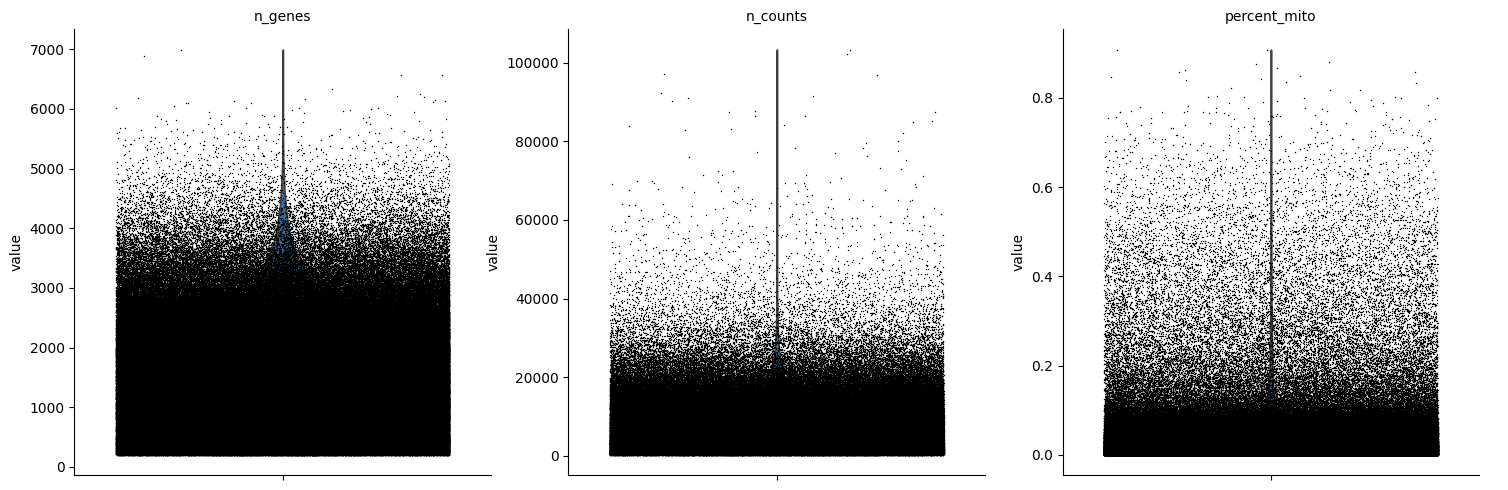

In [89]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

<Axes: title={'center': 'n genes'}, xlabel='n_counts', ylabel='n_genes'>

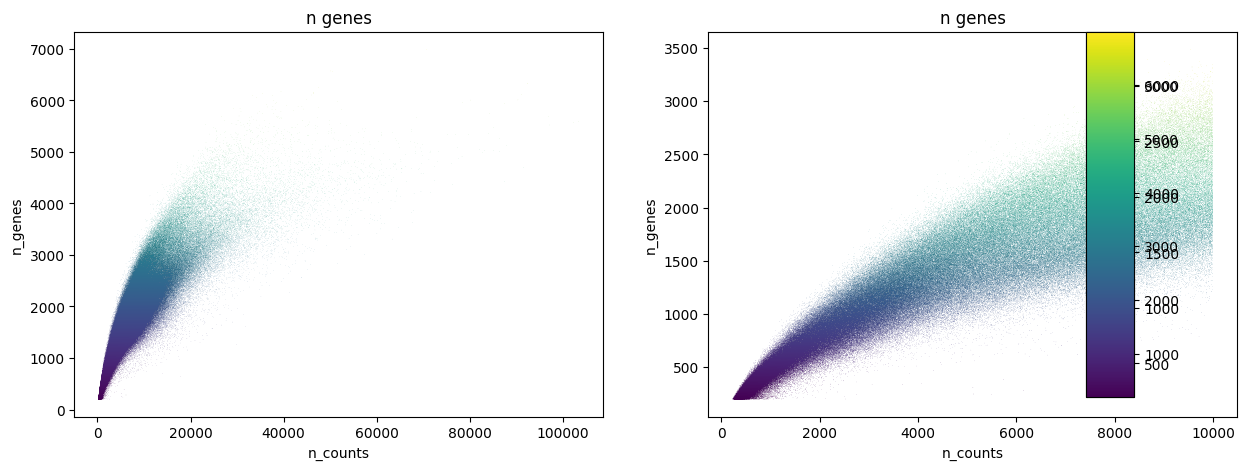

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='n_genes', show=False, ax=ax1)
sc.pl.scatter(adata[adata.obs['n_counts'] < 10000], x='n_counts', y='n_genes', color='n_genes', show=False, ax=ax2)

<Axes: title={'center': 'percent mito'}, xlabel='n_counts', ylabel='percent_mito'>

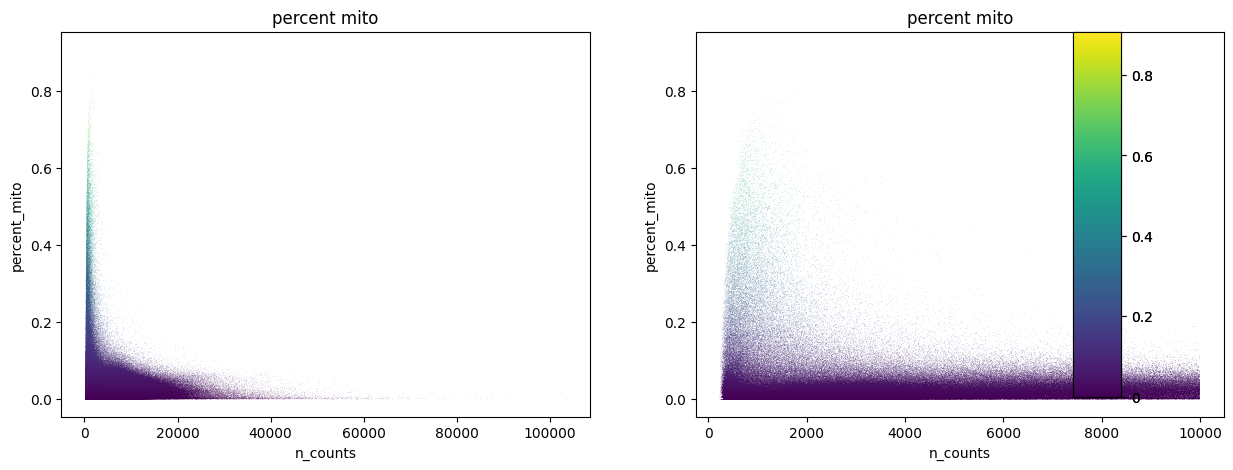

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color='percent_mito', show=False, ax=ax1)
sc.pl.scatter(adata[adata.obs['n_counts'] < 10000], x='n_counts', y='percent_mito', color='percent_mito', show=False, ax=ax2)

In [90]:
adata = adata[adata.obs['n_genes'] < 6000, :]
adata = adata[adata.obs['n_genes'] > 400, :]
adata = adata[adata.obs['n_counts'] > 1000, :]
adata = adata[adata.obs['percent_mito'] < 0.2, :]

In [91]:
adata

View of AnnData object with n_obs × n_vars = 466380 × 31025
    obs: 'sample_type', 'Donor', 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'n_cells'

In [92]:
adata.write_h5ad('/lustre/scratch126/cellgen/team298/ab72/CTCL/skinatlas_cellbender_raw_by_pasha_17_5_db_QC_removed.h5ad')

In [2]:
import scanpy as sc
adata=sc.read('/lustre/scratch126/cellgen/team298/ab72/CTCL/ctcl_cellbender_raw_by_pasha_15_5_QC_filtered.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 183672 × 29631
    obs: 'sample_type', 'Donor', 'Sanger_ID', 'batch', 'donor_lane', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'n_genes', 'percent_mito', 'n_counts', 'tech'
    var: 'gene_ids', 'feature_types', 'n_cells'